In [1]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=378b01eef02a18fb14b7953b9ea4d1b77c1fe20e81362e56406f2df6ec1a8301
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=a9cc82b7e65a2c2431aacb2b611a014663ae187c90d3c35597ffe3b6c64587df
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [2]:
import torch
import torch.nn as nn

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets
import torchvision.transforms as tr

In [3]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.encoder_layers = nn.Sequential(
            
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_size),
            nn.ReLU())

        self.fc_mu = torch.nn.Linear(latent_size, latent_size) #формирование вектора мат ожиданий
        self.fc_log_var = torch.nn.Linear(latent_size, latent_size) #формирование вектора логарифма дисперсий

        self.latent_size = latent_size

    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        x = self.encoder_layers(x)
 
        
        x = x.reshape(-1, self.latent_size) #делаем reshape, чтобы в полносвязку передать вектора
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var #результат кодера -- это вектор средних и вектор дисперсий
        # ============

    def sample_latent(self, x): #получаем вектор скрытого состояния Z
        mu, log_var = self.forward(x) #получае вектора средних и дисперсий

        #torch.randn_like(input) Возвращает тензор того же размера, 
        #что и input который заполнен случайными числами из стандартного нормального распределения
        N = torch.randn_like(mu).to(device)

        #дисперсия у нас возвращается в логарифме, а умножить нам надо на стандартное отклонение
        #тогда нужно /2, степень уходит и взять экспоненту, получим просто стандартное отклонение
        return torch.exp(log_var/2) * N + mu, mu, log_var

In [4]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        #ВАШ_КОД
        #нужно использовать torch.nn.UpsamplingNearest2d(scale_factor=2)
        self.decoder_layers = nn.Sequential(

            nn.Linear(latent_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid())


    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        # размер вывода должен соотвествовать размеру входа на кодер
        x = self.decoder_layers(x)

        return x


In [5]:
def train_ae(data_loader, encoder, decoder, epochs, lr, device):
    print('Обучение автокодировщика..')

    encoder.train()
    decoder.train()

    recon_loss_func = torch.nn.MSELoss()

    kl_loss_func = lambda mu, log_var: -0.5 * ((1 + log_var -  torch.exp(log_var) - mu**2).sum(dim=1)).mean(dim=0)

    optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)
    loss_history = list()
    loss=0
    for epoch in range(epochs):
        for i, (batch, _) in enumerate(data_loader):

            batch = batch.to(device)

            optimizer.zero_grad()
            #прямой проход через кодер и получение вектора Z, вектора средних и вектора дисперсий
            latent_vector, mu, log_sigma = encoder.sample_latent(batch) 

            #получение ошибки MSE
    
            recon_loss = recon_loss_func(decoder(latent_vector), torch.flatten(batch, start_dim = 1))

            #получение ошибки KL
            kl_loss = kl_loss_func(mu, log_sigma)
            loss = kl_loss + 1000 * recon_loss

            
            loss.backward()
            optimizer.step()       

            if i % 100 == 0:
                print('Потери восстановления:', recon_loss.item())
                print('Потери расхождения распределений:', kl_loss.item())

            loss_history.append(loss.log().item())

        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')
    # ============

    encoder.eval()
    decoder.eval()

    print('Готово!')

    plt.plot(loss_history)
    plt.show()

In [6]:
LATENT_SIZE = 50  # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 500 # можно варьировать.
EPOCHS = 15 # можно варьировать.
LEARNING_RATE = 0.001 # можно варьировать.

device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)

In [7]:
data = torchvision.datasets.MNIST('./', download = True, train = True, transform = tr.ToTensor())
train_data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 188231856.23it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 118181164.71it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 71169450.96it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7568744.05it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Обучение автокодировщика..
Потери восстановления: 0.23102430999279022
Потери расхождения распределений: 0.29162508249282837
Потери восстановления: 0.06317420303821564
Потери расхождения распределений: 1.2617387771606445
Эпоха 1 / 15. Потери на последнем пакете: 64.2950668334961
Потери восстановления: 0.06397443264722824
Потери расхождения распределений: 1.2965291738510132
Потери восстановления: 0.05950852856040001
Потери расхождения распределений: 2.2425801753997803
Эпоха 2 / 15. Потери на последнем пакете: 63.72911834716797
Потери восстановления: 0.05909503996372223
Потери расхождения распределений: 2.546687126159668
Потери восстановления: 0.053031258285045624
Потери расхождения распределений: 4.241913318634033
Эпоха 3 / 15. Потери на последнем пакете: 54.44609069824219
Потери восстановления: 0.051360126584768295
Потери расхождения распределений: 5.052036762237549
Потери восстановления: 0.04446715489029884
Потери расхождения распределений: 6.130517482757568
Эпоха 4 / 15. Потери на пос

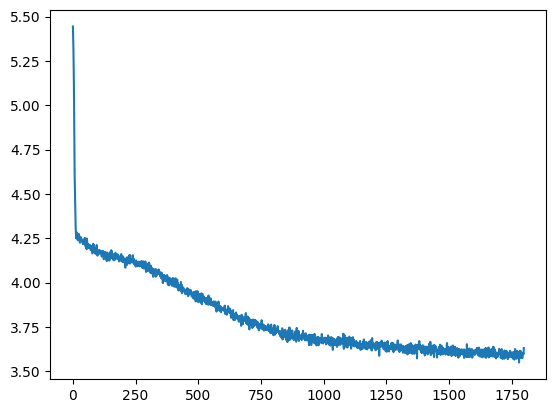

In [8]:
train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE, device)

In [9]:
MNIST_test=torchvision.datasets.MNIST('./', download = True, train = False)

In [10]:
X_test = MNIST_test.train_data/255

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [11]:
X_test = X_test.unsqueeze(1).to(device)

In [12]:
Z = encoder.sample_latent(X_test)[0] #скрытое пространство

In [13]:
import umap
import seaborn as sns

In [14]:
result=pd.DataFrame(Z.detach().cpu().numpy())

In [15]:
result.head(5) #получили 10000 объектов в скрытом состоянии

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.600035,-1.737360,1.348280,0.866503,2.072973,-0.665930,-1.419766,3.106109,0.288902,-0.861439,...,1.397694,1.806610,-0.402486,-0.718626,0.665054,1.122778,0.246895,-0.114985,0.883539,-0.497321
1,0.903786,0.602926,0.926885,-1.028085,-1.219504,-0.846161,-1.315348,-1.314183,-0.585767,-0.506550,...,0.146415,0.411160,-0.339739,-0.046896,0.270780,0.074872,0.622045,1.009393,-0.420132,2.544907
2,0.666709,-0.638907,-1.989654,0.488322,1.843481,-0.228686,-1.231101,1.277801,0.067413,0.237919,...,2.032103,0.248173,1.046875,0.622482,0.660284,1.638747,-0.244969,0.510494,-0.201002,0.776077
3,-0.475003,0.002859,-1.696457,0.325102,-0.865849,-0.878822,1.010299,0.161124,0.596485,0.627436,...,-1.160304,-0.053369,0.562211,-0.956763,0.285534,0.495087,-0.325153,0.806536,-1.391739,0.159679
4,0.860457,2.242083,-1.093861,0.787052,-0.342339,1.174810,-0.377407,0.449972,0.651772,0.287202,...,-0.909150,-0.192538,0.391513,0.207365,1.121591,-0.810650,-0.030221,0.367522,-0.205655,-0.139929


In [16]:
a=umap.UMAP(random_state=123).fit_transform(result)

In [17]:
d = {'col1': a[:,0], 'col2': a[:,1]}
a = pd.DataFrame(data=d)
a['label'] = MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [18]:
print(a)

          col1      col2  label
0     5.640883  4.730675      7
1     4.888031  3.027607      2
2     2.661056  5.446456      1
3     5.046230  4.522599      0
4     5.268662  6.860565      4
...        ...       ...    ...
9995  4.489375  5.200511      2
9996  5.385450  3.950663      3
9997  3.023747  4.958919      4
9998  2.491606  4.985428      5
9999  3.648503  4.491092      6

[10000 rows x 3 columns]


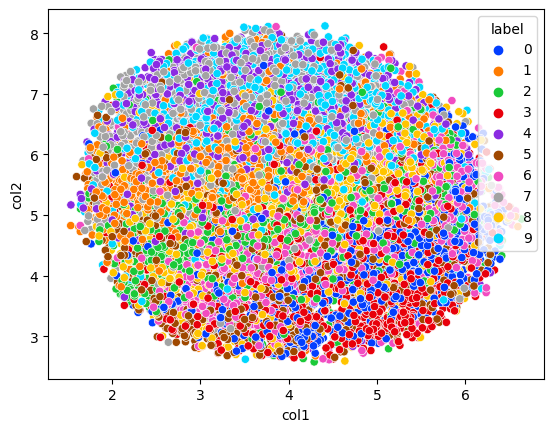

In [19]:
fig = plt.figure()
sns.scatterplot(x='col1',y='col2',data=a, palette='bright', hue=a['label'])
plt.show()

In [20]:
means = result.mean(axis=0)
vars = result.std(axis=0)**2

(array([ 1.,  0.,  1., 13., 23., 11.,  0.,  0.,  0.,  1.]),
 array([-0.10127078, -0.07816885, -0.05506692, -0.03196498, -0.00886305,
         0.01423888,  0.03734081,  0.06044274,  0.08354467,  0.1066466 ,
         0.12974854]),
 <BarContainer object of 10 artists>)

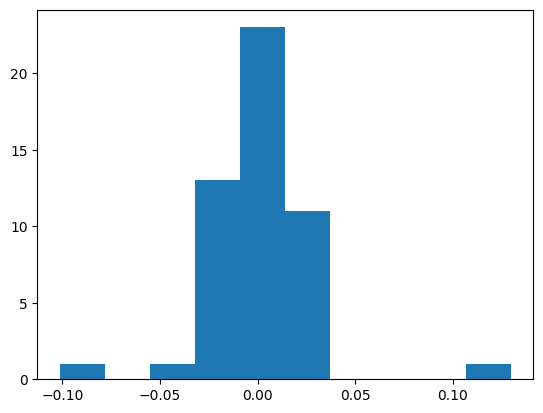

In [21]:
plt.hist(means)

(array([17., 20.,  8.,  1.,  2.,  0.,  0.,  1.,  0.,  1.]),
 array([0.96971279, 0.99419016, 1.01866758, 1.04314494, 1.0676223 ,
        1.09209967, 1.11657703, 1.14105439, 1.16553175, 1.19000912,
        1.21448648]),
 <BarContainer object of 10 artists>)

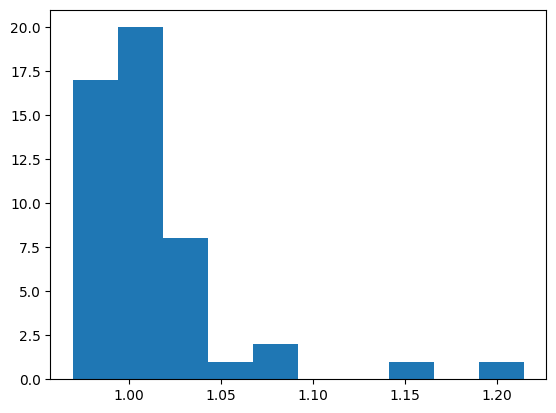

In [22]:
plt.hist(vars)

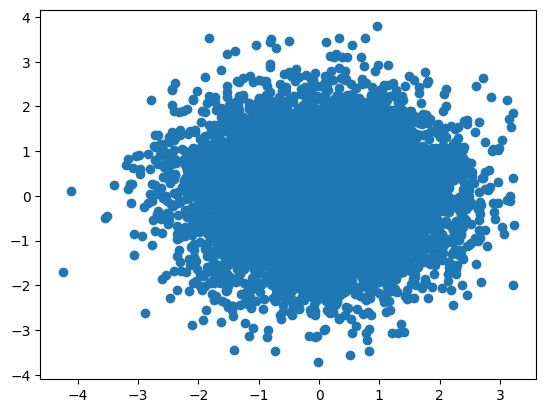

In [23]:
plt.scatter(result.iloc[:,0],result.iloc[:,1])

In [24]:
restored_imgs = decoder(Z[:5].reshape(5, 50))
restored_imgs = restored_imgs.reshape(5, 1, 28, 28)

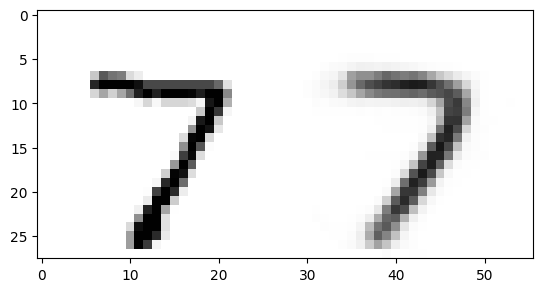

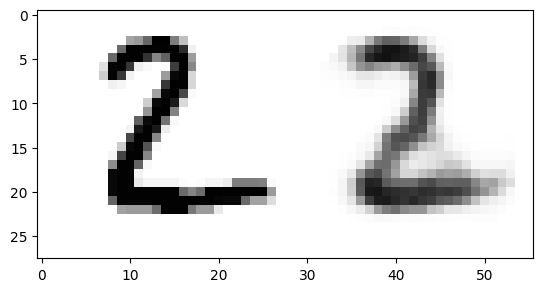

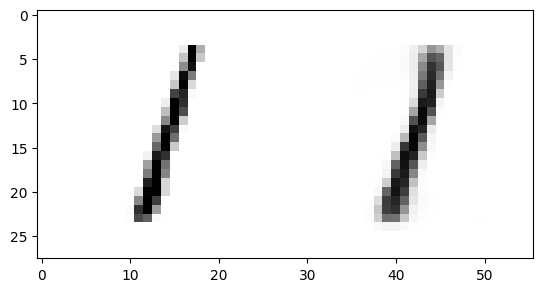

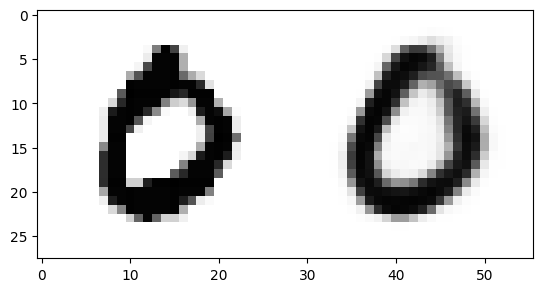

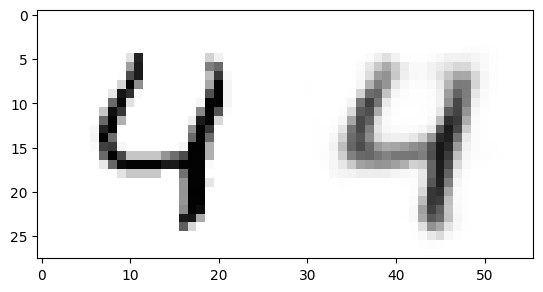

In [25]:
for i in range(restored_imgs.shape[0]):
  orig_restored = torch.hstack((X_test[i][0], restored_imgs[i][0].detach()))
  plt.imshow(orig_restored.cpu().numpy(), cmap='Greys')
  plt.show()

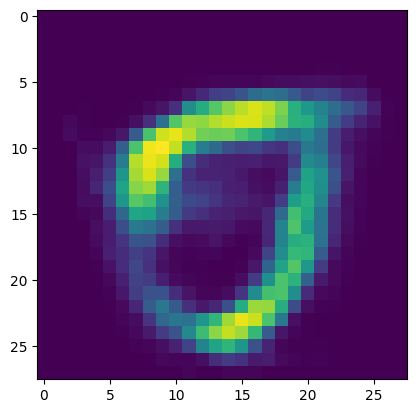

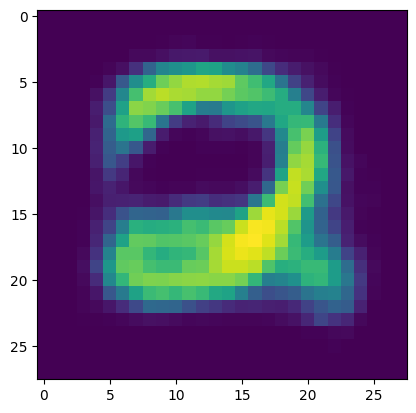

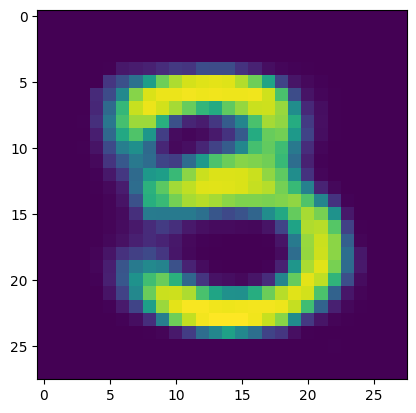

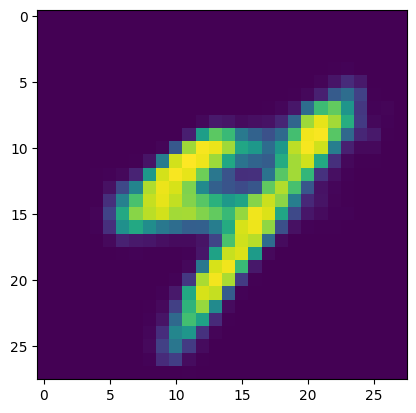

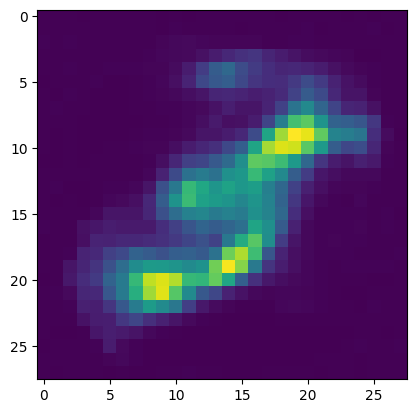

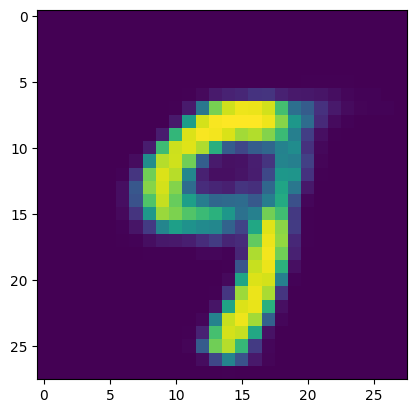

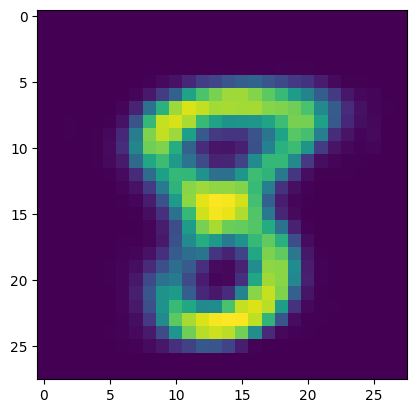

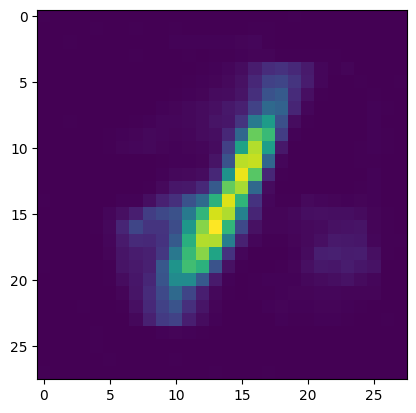

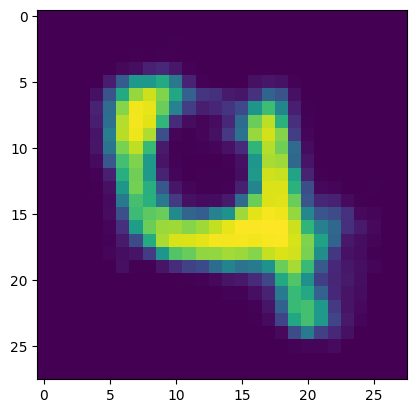

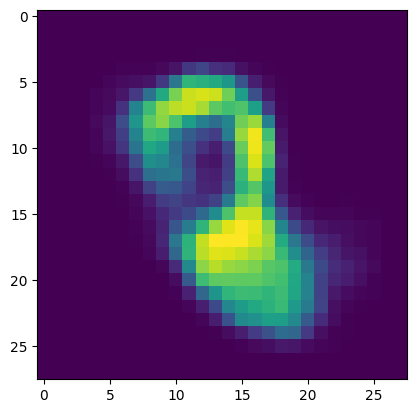

In [26]:
#генерация новых точек 

for _ in range(10):
    gen_latent = torch.randn(123, LATENT_SIZE, device=device)
    gen_digit = decoder(gen_latent.reshape(123, 50)).cpu()
    plt.imshow(gen_digit.detach()[0].reshape(28, 28).numpy())
    plt.show()